In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#import math

In [51]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:1000] #limitando o dataset, pra memória n explodir
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente']]
    #grouped = df.groupby(['bairroPaciente'])
    bairros = pd.unique(df['bairroPaciente'])

    clusters = []
    for bairro in bairros:
        cluster = []
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                if(df.loc[i][2] == 'Positivo'):
                    resultado = 1
                else:
                    resultado = 0
                cluster.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3]])
        clusters.append(cluster)

    novo_df = []
    for cluster in clusters:
        for i in range(len(cluster)):
            novo_df.append(cluster[i])

    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente'}, inplace=True)    
    return novo_df

In [52]:
df = pre_processamento()

In [53]:
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO
1,VARJOTA,FORTALEZA,0,FEMININO
2,VARJOTA,PACATUBA,0,FEMININO
3,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO
4,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO
...,...,...,...,...
995,MANGA,BATURITÉ,1,FEMININO
996,MORADA DOS VENTOS 1,CRATEUS,0,FEMININO
997,PRACINHA,PACATUBA,1,FEMININO
998,FLORES,ITAPIPOCA,1,MASCULINO


In [54]:
def ajustar(df):
    bairros = pd.unique(df['bairro_paciente'])
    casos_bairros = []
    for bairro in bairros:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][0] == bairro):
                count = count + 1
        casos_bairros.append([bairro, count])
    casos_bairros = pd.DataFrame(casos_bairros)
    casos_bairros.rename(columns={0: 'bairro', 1: 'count'}, inplace=True)
    return casos_bairros

In [55]:
dataset = ajustar(df)
dataset

,bairro,count
0,VILA PERI,1
1,VARJOTA,2
2,NOVA METROPOLE JUREMA,1
3,PARQUE POTIRA JUREMA,1
4,PINHEIRO,1
...,...,...
494,MANGA,1
495,MORADA DOS VENTOS 1,1
496,PRACINHA,1
497,FLORES,1


In [56]:
def query_topk(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmax()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])#(copia.loc[indice][0])#
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output

In [62]:
query_topk(dataset, 10)

,bairro,count
0,CENTRO,190
1,ZONA RURAL,46
2,ARATURI,13
3,SANTO ANTONIO,9
4,PLANALTO,8
5,JURITIANHA,8
6,JUREMA,7
7,PAVUNA,7
8,NOVO MARANGUAPE,7
9,PRECABURA,6


In [58]:
def score_function(registro, saida):
    if(registro[0] == saida):
        return registro[1]
    else:
        return 0

In [59]:
def sensibilidade(dataset):
    return np.max(np.array(dataset['count']))

In [178]:
sensibilidade(dataset)

190

In [197]:
def dp_query(budget, sensibilidade, dataset, k):
    budget = budget/k
    probabilidades = []
    pk = []
    saidas = dataset['bairro']
    xk = np.arange(len(saidas))
    for out in saidas:
        linha = []
        for i in range(len(dataset)):
            registro = dataset.loc[i]
            numerador = np.exp(budget*score_function(registro,out)/(2*sensibilidade))
            denominador = 0
            for saida in saidas:
                denominador += np.exp(budget*score_function(registro, saida)/(2*sensibilidade))
            linha.append(numerador/denominador)
        probabilidades.append(linha)
    for prob in probabilidades:
        pk.append(np.sum(prob)/np.sum(probabilidades))
    dist = stats.rv_discrete(name='dist', values=(xk, pk))
    output = []

    for i in range(k):
        valido = False
        while(not valido):
            indice = dist.rvs()
            if([saidas[indice], dataset.loc[indice][1]] not in output):
                output.append([saidas[indice], dataset.loc[indice][1]])
                valido = True
        
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'bairro', 1: 'count'})
    return output.sort_values(by=['count'],ascending=False)

In [176]:
budgets = [0.1, 1, 10]
counts = []
k = 10
for budget in budgets:
    a = dp_query(budget, sensibilidade(dataset), dataset, k)
    a = np.array(a)
    print("epsilon: {}\ntop-k:\n{}\n\n".format(budget, a))
    counts.append(a[:,1])

epsilon: 0.1
top-k:
[['NOSSA SENHORA DE FATIMA' 4]
 ['BELA VISTA' 4]
 ['TIRADENTES' 2]
 ['URUCUNEMA' 1]
 ['VAMOS VER' 1]
 ['SÍTIO ESTRELA' 1]
 ['LIMOEIRO' 1]
 ['EDMAR BARREIRA' 1]
 ['TUÍNA' 1]
 ['NOVO AQUIRAZ' 1]]


epsilon: 1
top-k:
[['JEREISSATI I' 2]
 ['SÃO GERALDO' 2]
 ['SEDE IV' 2]
 ['FREI DAMIÃO' 1]
 ['NOVO AQUIRAZ' 1]
 ['ALTO SÃO JOÃO' 1]
 ['PARQUE ARATANHA' 1]
 ['PEDRAS DO ANCURI' 1]
 ['SANTA TEREZA' 1]
 ['BOA VIZINHANÇA 2' 1]]


epsilon: 10
top-k:
[['JUNCO' 4]
 ['JERICOACOARA' 2]
 ['JARDIM BANDEIRANTE' 2]
 ['PARAZINHO' 1]
 ['SANTO ANTÔNIO' 1]
 ['IRACEMA' 1]
 ['JORDÃO - DISTRITO' 1]
 ['PEDRAS DO ANCURI' 1]
 ['LIMOEIRO' 1]
 ['ESF AR' 1]]




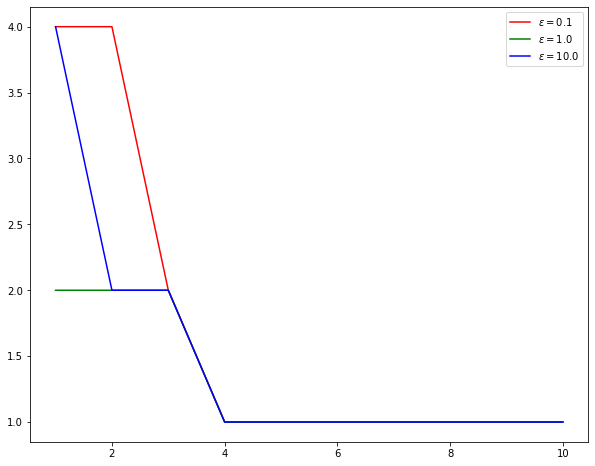

In [177]:
cores = ['red', 'green', 'blue']
eixo_x = np.arange(start=1, stop=k+1, step=1)
fig, ax = plt.subplots(figsize=(10, 8))
for count, budget, cor in zip(counts, budgets, cores):    
    plt.plot(eixo_x, count, ls='-', c=cor, label=r'$\epsilon = %.1f$' % (budget))
plt.legend()
plt.subplots_adjust(wspace=1)
plt.show()